<a href="https://colab.research.google.com/github/CyrusCce/creditcard_fraud/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.2 MB/s eta 0:00:00


## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [4]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [6]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.02392517  0.03194136  0.02266178  0.02330189]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [7]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.02328634 -0.16349813  0.02312782  0.32304785]
Reward for this step: 1.0
Is this round done? False


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [8]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [9]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

For Task 1, we can show the observation and chosen action below:

In [10]:
observation = env.reset()
action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.01738597 -0.00277747  0.01277285  0.00053624]
Chosen action: 1


In [13]:
import gym
env = gym.make('CartPole-v1')
observation = env.reset()
done = False
while not done:
    action = 1 if observation[2] < 0 else 0  # If the pole angle is negative, push right (action 1)
    observation, reward, done, info = env.step(action)
    print("Observation:", observation)
    print("Chosen action:", action)
env.close()


Observation: [ 2.4930085e-04 -1.8902934e-01  2.8883079e-02  3.1493160e-01]
Chosen action: 0
Observation: [-0.00353129 -0.38455057  0.03518171  0.61658156]
Chosen action: 0
Observation: [-0.0112223  -0.5801459   0.04751334  0.9201343 ]
Chosen action: 0
Observation: [-0.02282522 -0.7758767   0.06591603  1.2273629 ]
Chosen action: 0
Observation: [-0.03834275 -0.97178227  0.09046329  1.5399482 ]
Chosen action: 0
Observation: [-0.05777839 -1.1678684   0.12126225  1.8594347 ]
Chosen action: 0
Observation: [-0.08113576 -1.3640943   0.15845095  2.187176  ]
Chosen action: 0
Observation: [-0.10841765 -1.5603569   0.20219447  2.5242717 ]
Chosen action: 0
Observation: [-0.13962479 -1.7564731   0.2526799   2.8714943 ]
Chosen action: 0


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Total Reward = 393.0
Episode 2: Total Reward = 219.0
Episode 3: Total Reward = 191.0
Episode 4: Total Reward = 318.0
Episode 5: Total Reward = 300.0
Episode 6: Total Reward = 223.0
Episode 7: Total Reward = 435.0
Episode 8: Total Reward = 277.0
Episode 9: Total Reward = 243.0
Episode 10: Total Reward = 361.0
Episode 11: Total Reward = 335.0
Episode 12: Total Reward = 186.0
Episode 13: Total Reward = 247.0
Episode 14: Total Reward = 273.0
Episode 15: Total Reward = 265.0
Episode 16: Total Reward = 273.0
Episode 17: Total Reward = 335.0
Episode 18: Total Reward = 243.0
Episode 19: Total Reward = 195.0
Episode 20: Total Reward = 291.0
Episode 21: Total Reward = 249.0
Episode 22: Total Reward = 295.0
Episode 23: Total Reward = 193.0
Episode 24: Total Reward = 287.0
Episode 25: Total Reward = 397.0
Episode 26: Total Reward = 261.0
Episode 27: Total Reward = 223.0
Episode 28: Total Reward = 291.0
Episode 29: Total Reward = 299.0
Episode 30: Total Reward = 253.0
Episode 31: Total R

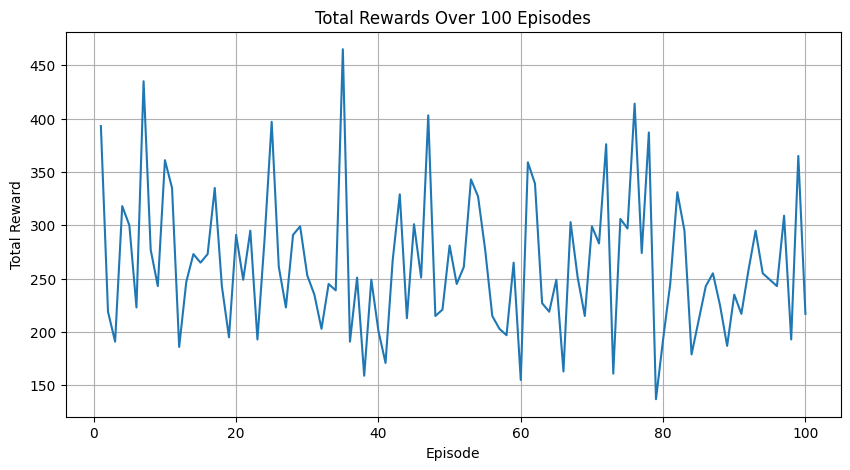

In [29]:
import gym
import matplotlib.pyplot as plt

# Create the CartPole environment
env = gym.make('CartPole-v1')

# Define a stricter heuristic policy based on the pole's angle (with new thresholds)
def stricter_policy(observation):
    # observation[0] is the cart position
    # observation[1] is the cart velocity
    # observation[2] is the pole angle (in radians)
    # observation[3] is the pole angular velocity
    cart_velocity = observation[1]
    pole_angle = observation[2]

    # Thresholds for stricter behavior
    high_threshold = 0.3   # Threshold for 30 degrees
    low_threshold = 0.1    # Threshold for stabilization
    velocity_threshold = 0.5  # Threshold for cart velocity

    # If the pole angle is greater than +0.3 radians, push left (action 0) until it gets below 0.1
    if pole_angle > high_threshold:
        action = 0  # Push left until the angle is reduced to 0.1 radians

    # If the pole angle is less than -0.3 radians, push right (action 1) until it gets above -0.1
    elif pole_angle < -high_threshold:
        action = 1  # Push right until the angle is increased to -0.1 radians

    # If the pole angle is between -0.3 and 0.3 radians, stabilize it
    elif pole_angle > low_threshold:
        action = 0  # Push left to reduce the angle
    elif pole_angle < -low_threshold:
        action = 1  # Push right to increase the angle
    else:
        # If within the range of -0.1 to 0.1, try to stabilize by pushing in the appropriate direction
        action = 0 if pole_angle < 0 else 1  # Push left if tilt left, push right if tilt right

    # Adjust for cart velocity to keep it within the desired range of +-0.5
    if cart_velocity > velocity_threshold:
        # If cart velocity is too high and moving right, push left (action 0) to slow down
        action = 0
    elif cart_velocity < -velocity_threshold:
        # If cart velocity is too high and moving left, push right (action 1) to slow down
        action = 1

    return action

# List to store rewards per episode
rewards_per_episode = []

# Run for 1000 episodes
for episode in range(100):
    observation = env.reset()  # Reset the environment to get the initial state
    total_reward = 0
    done = False

    while not done:
        # Get the action from the stricter policy and take a step in the environment
        action = stricter_policy(observation)
        observation, reward, _, info = env.step(action)

        # Define the custom termination conditions
        cart_position = observation[0]
        pole_angle = observation[2]

        # Termination: Pole angle exceeds ±0.418 radians (~±24°) or cart position exceeds ±4.8
        if abs(pole_angle) > 0.418 or abs(cart_position) > 4.8:
            done = True  # End the episode if conditions are met

        total_reward += reward

    rewards_per_episode.append(total_reward)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

# Close the environment after all episodes
env.close()

# Plotting the total rewards for each episode
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), rewards_per_episode, label="Total Reward per Episode")
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards Over 100 Episodes')
plt.grid(True)
plt.show()


Episode 1: Total Reward = 9.0 (Epsilon: 0.995)
Episode 2: Total Reward = 8.0 (Epsilon: 0.990)
Episode 3: Total Reward = 8.0 (Epsilon: 0.985)
Episode 4: Total Reward = 9.0 (Epsilon: 0.980)
Episode 5: Total Reward = 11.0 (Epsilon: 0.975)
Episode 6: Total Reward = 9.0 (Epsilon: 0.970)
Episode 7: Total Reward = 10.0 (Epsilon: 0.966)
Episode 8: Total Reward = 11.0 (Epsilon: 0.961)
Episode 9: Total Reward = 10.0 (Epsilon: 0.956)
Episode 10: Total Reward = 9.0 (Epsilon: 0.951)
Episode 11: Total Reward = 8.0 (Epsilon: 0.946)
Episode 12: Total Reward = 8.0 (Epsilon: 0.942)
Episode 13: Total Reward = 8.0 (Epsilon: 0.937)
Episode 14: Total Reward = 8.0 (Epsilon: 0.932)
Episode 15: Total Reward = 8.0 (Epsilon: 0.928)
Episode 16: Total Reward = 9.0 (Epsilon: 0.923)
Episode 17: Total Reward = 11.0 (Epsilon: 0.918)
Episode 18: Total Reward = 8.0 (Epsilon: 0.914)
Episode 19: Total Reward = 26.0 (Epsilon: 0.909)
Episode 20: Total Reward = 10.0 (Epsilon: 0.905)
Episode 21: Total Reward = 9.0 (Epsilon: 0

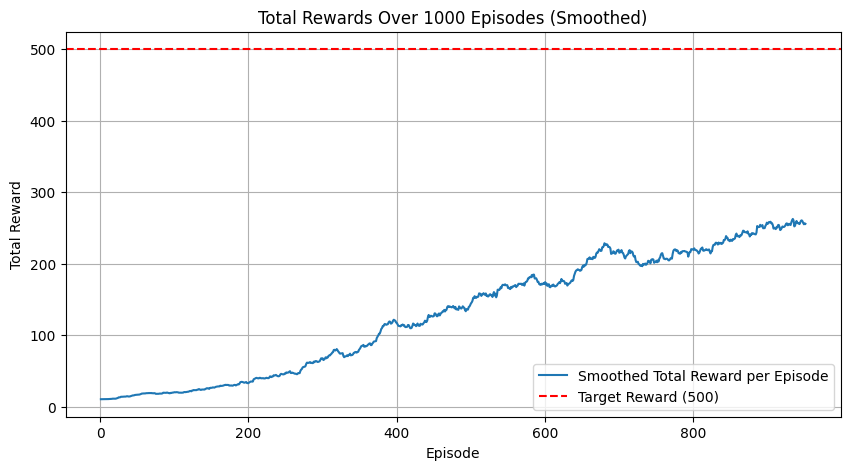

In [33]:
import gym
import matplotlib.pyplot as plt
import numpy as np

# Create the CartPole environment
env = gym.make('CartPole-v1')

# Define a stricter heuristic policy based on the pole's angle and velocity with adaptive exploration
def stricter_policy(observation, epsilon):
    # observation[0] is the cart position
    # observation[1] is the cart velocity
    # observation[2] is the pole angle (in radians)
    # observation[3] is the pole angular velocity
    cart_velocity = observation[1]
    pole_angle = observation[2]
    pole_angular_velocity = observation[3]

    # Thresholds for stricter behavior
    high_threshold = 0.3   # Threshold for 30 degrees
    low_threshold = 0.1    # Threshold for stabilization
    velocity_threshold = 0.5  # Threshold for cart velocity

    # Define a base policy (deterministic)
    if pole_angle > high_threshold:
        action = 0  # Push left until the angle is reduced
    elif pole_angle < -high_threshold:
        action = 1  # Push right until the angle is increased
    elif pole_angle > low_threshold:
        action = 0  # Push left to reduce the angle
    elif pole_angle < -low_threshold:
        action = 1  # Push right to increase the angle
    else:
        # If within the range of -0.1 to 0.1, stabilize by pushing left or right
        action = 0 if pole_angle < 0 else 1

    # Adjust for cart velocity
    if cart_velocity > velocity_threshold:
        action = 0
    elif cart_velocity < -velocity_threshold:
        action = 1

    # Gradually introduce exploration with decreasing epsilon
    if np.random.rand() < epsilon:  # epsilon-greedy strategy
        action = 1 - action  # Randomly switch the action

    return action

# List to store rewards per episode
rewards_per_episode = []

# Total number of episodes
total_episodes = 1000

# Initial epsilon value for exploration
epsilon = 1.0  # Start with full exploration
epsilon_decay = 0.995  # Decay factor for epsilon
min_epsilon = 0.001  # Minimum epsilon value to ensure some exploration

# Run for multiple episodes
for episode in range(total_episodes):
    observation = env.reset()  # Reset the environment to get the initial state
    total_reward = 0
    done = False

    while not done:
        # Get the action from the stricter policy with the current epsilon
        action = stricter_policy(observation, epsilon)
        observation, reward, _, info = env.step(action)

        # Define the custom termination conditions
        cart_position = observation[0]
        pole_angle = observation[2]

        # Termination: Pole angle exceeds ±0.418 radians (~±24°) or cart position exceeds ±4.8
        if abs(pole_angle) > 0.418 or abs(cart_position) > 4.8:
            done = True  # End the episode if conditions are met

        total_reward += reward

    rewards_per_episode.append(total_reward)

    # Decay epsilon after each episode
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    print(f"Episode {episode + 1}: Total Reward = {total_reward} (Epsilon: {epsilon:.3f})")

# Close the environment after all episodes
env.close()

# Apply a moving average to smooth the reward curve
window_size = 50  # Size of the window for moving average
smoothed_rewards = np.convolve(rewards_per_episode, np.ones(window_size)/window_size, mode='valid')

# Plotting the total rewards for each episode
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards, label="Smoothed Total Reward per Episode")
plt.axhline(y=500, color='r', linestyle='--', label="Target Reward (500)")
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f'Total Rewards Over {total_episodes} Episodes (Smoothed)')
plt.grid(True)
plt.legend()
plt.show()


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

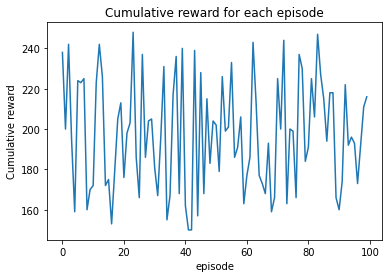

In [ ]:
episode_results = np.random.randint(150, 250, size=100)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 197.43
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [36]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = rand_policy_agent(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [38]:
import gym
import matplotlib.pyplot as plt
from gym.wrappers import RecordVideo
from IPython.display import Video

# Create the CartPole environment and wrap it to record video
env = RecordVideo(gym.make("CartPole-v1"), "./video")

# Define a stricter heuristic policy based on the pole's angle (with new thresholds)
def stricter_policy(observation):
    # observation[0] is the cart position
    # observation[1] is the cart velocity
    # observation[2] is the pole angle (in radians)
    # observation[3] is the pole angular velocity
    cart_velocity = observation[1]
    pole_angle = observation[2]

    # Thresholds for stricter behavior
    high_threshold = 0.3   # Threshold for 30 degrees
    low_threshold = 0.1    # Threshold for stabilization
    velocity_threshold = 0.5  # Threshold for cart velocity

    # If the pole angle is greater than +0.3 radians, push left (action 0) until it gets below 0.1
    if pole_angle > high_threshold:
        action = 0  # Push left until the angle is reduced to 0.1 radians

    # If the pole angle is less than -0.3 radians, push right (action 1) until it gets above -0.1
    elif pole_angle < -high_threshold:
        action = 1  # Push right until the angle is increased to -0.1 radians

    # If the pole angle is between -0.3 and 0.3 radians, stabilize it
    elif pole_angle > low_threshold:
        action = 0  # Push left to reduce the angle
    elif pole_angle < -low_threshold:
        action = 1  # Push right to increase the angle
    else:
        # If within the range of -0.1 to 0.1, try to stabilize by pushing in the appropriate direction
        action = 0 if pole_angle < 0 else 1  # Push left if tilt left, push right if tilt right

    # Adjust for cart velocity to keep it within the desired range of +-0.5
    if cart_velocity > velocity_threshold:
        # If cart velocity is too high and moving right, push left (action 0) to slow down
        action = 0
    elif cart_velocity < -velocity_threshold:
        # If cart velocity is too high and moving left, push right (action 1) to slow down
        action = 1

    return action

# Test the policy on one game and record the video
def test_single_game():
    observation = env.reset()  # Reset the environment to get the initial state
    total_reward = 0
    done = False

    while not done:
        env.render()  # Render the environment to visualize the game

        # Get the action from the stricter policy and take a step in the environment
        action = stricter_policy(observation)
        observation, reward, done, info = env.step(action)

        # Define the custom termination conditions
        cart_position = observation[0]
        pole_angle = observation[2]

        # Termination: Pole angle exceeds ±0.418 radians (~±24°) or cart position exceeds ±4.8
        if abs(pole_angle) > 0.418 or abs(cart_position) > 4.8:
            done = True  # End the episode if conditions are met

        total_reward += reward

    print(f"Final Total Reward from the Game: {total_reward}")

# Run the test for one game
test_single_game()

# Close the environment after the test
env.close()

# Display the recorded video
# Adjust the video filename if necessary
Video("./video/rl-video-episode-0.mp4")


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Final Total Reward from the Game: 185.0
